In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
# !rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-29 11:28:07.072420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 11:28:07.538078: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 11:28:09.198302: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_ensemble


In [2]:
oof_xgb = pd.read_csv(f'/kaggle/output/{CFG["xgb_model"]["execution"]["best_exp_id"]}/oof.csv')
oof_xgb.head()

,series_id,step,score,event
0,038441c925bb,389,-0.010521,wakeup
1,038441c925bb,389,-0.008024,onset
2,038441c925bb,401,-0.004696,wakeup
3,038441c925bb,401,-0.008815,onset
4,038441c925bb,413,0.056987,wakeup


In [3]:
oof_lgb = pd.read_csv(f'/kaggle/output/{CFG["lgb_model"]["execution"]["best_exp_id"]}/oof.csv')
oof_lgb.head()

,series_id,step,score,event
0,038441c925bb,389,0.020495,wakeup
1,038441c925bb,389,0.001718,onset
2,038441c925bb,401,0.009902,wakeup
3,038441c925bb,401,-0.003201,onset
4,038441c925bb,413,0.012900,wakeup


In [4]:
oof_gru = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_gru.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.002176,0.000528
1,05e1944c3818,18,0.001254,0.000455
2,05e1944c3818,30,0.000961,0.000438
3,05e1944c3818,42,0.000820,0.000427
4,05e1944c3818,54,0.000760,0.000409


In [5]:
oof_wave = pd.read_parquet(f'/kaggle/output/{CFG["patch_wavenet_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_wave.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.001227,0.000117
1,05e1944c3818,18,0.000792,0.000102
2,05e1944c3818,30,0.000555,0.000075
3,05e1944c3818,42,0.000588,0.000096
4,05e1944c3818,54,0.000582,0.000090


In [6]:
oof_1d = pd.read_parquet(f'/kaggle/output/{CFG["patch_1dcnn_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_1d.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.000804,0.000219
1,05e1944c3818,18,0.000680,0.000181
2,05e1944c3818,30,0.000657,0.000171
3,05e1944c3818,42,0.000631,0.000175
4,05e1944c3818,54,0.000543,0.000188


In [7]:
oof_tubo_based = pd.read_parquet(f'/kaggle/output/tubo_based/exp019_oof.parquet')
oof_tubo_based.head()

,series_id,step,onset_oof,wakeup_oof
0,05e1944c3818,0,0.033760,0.012846
1,05e1944c3818,1,0.026779,0.009975
2,05e1944c3818,2,0.012798,0.004220
3,05e1944c3818,3,0.005708,0.001657
4,05e1944c3818,4,0.005488,0.002279


In [8]:
dfs = []
for seires_id, df_tubo_based in tqdm(oof_tubo_based.groupby("series_id")):
    df_gru = oof_gru[oof_gru["series_id"]==seires_id]
    df_wave = oof_wave[oof_wave["series_id"]==seires_id]
    df_1d = oof_1d[oof_1d["series_id"]==seires_id]
    df_xgb = oof_xgb[oof_xgb["series_id"]==seires_id]
    df_lgb = oof_lgb[oof_lgb["series_id"]==seires_id]
    df = df_tubo_based

    # tubo based
    df["onset_oof_tubo_based"] = df["onset_oof"] / 1.5
    df["wakeup_oof_tubo_based"] = df["wakeup_oof"] / 1.5

    # gru
    df["onset_oof_gru"] = df["step"].map(df_gru.set_index("step")["onset_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_gru"] = df["step"].map(df_gru.set_index("step")["wakeup_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # wave
    df["onset_oof_wave"] = df["step"].map(df_wave.set_index("step")["onset_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_wave"] = df["step"].map(df_wave.set_index("step")["wakeup_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # 1d
    df["onset_oof_1d"] = df["step"].map(df_1d.set_index("step")["onset_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_1d"] = df["step"].map(df_1d.set_index("step")["wakeup_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # xgb
    xgb_wakeup = df_xgb[df_xgb["event"]=="wakeup"]
    df["wakeup_oof_xgb"] = df["step"].map(xgb_wakeup.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    xgb_onset = df_xgb[df_xgb["event"]=="onset"]
    df["onset_oof_xgb"] = df["step"].map(xgb_onset.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # lgb
    lgb_wakeup = df_lgb[df_lgb["event"]=="wakeup"]
    df["wakeup_oof_lgb"] = df["step"].map(lgb_wakeup.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    lgb_onset = df_lgb[df_lgb["event"]=="onset"]
    df["onset_oof_lgb"] = df["step"].map(lgb_onset.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    
    df["wakeup_oof"] = (
          df["wakeup_oof_gru"] * 0.17
        + df["wakeup_oof_wave"] * 0.17
        + df["wakeup_oof_1d"] * 0.17
        + df["wakeup_oof_xgb"] * 0.1 
        + df["wakeup_oof_lgb"] * 0.1
        + df["wakeup_oof_tubo_based"] * 0.3
    )
    df["onset_oof"] = (
          df["onset_oof_gru"] * 0.17
        + df["onset_oof_wave"] * 0.17
        + df["onset_oof_1d"] * 0.17
        + df["onset_oof_xgb"] * 0.1 
        + df["onset_oof_lgb"] * 0.1 
        + df["onset_oof_tubo_based"] * 0.3
    )

    # df["wakeup_oof"] = df["wakeup_oof_gru"] * 0.6 + df["wakeup_oof_xgb"] * 0.2 + df["wakeup_oof_lgb"] * 0.2 * df["wakeup_oof_tubo_based"] * 0
    # df["onset_oof"] = df["onset_oof_gru"] * 0.6 + df["onset_oof_xgb"] * 0.2 + df["onset_oof_lgb"] * 0.2 * df["onset_oof_tubo_based"] * 0

    df = df[["series_id", "step", "wakeup_oof", "onset_oof"]].reset_index(drop=True)
    dfs.append(df)
oof_df = pd.concat(dfs)
oof_df = oof_df[oof_df["step"] % 12 == 6]
oof_df.to_csv(f'{CFG["output_dir"]}/oof.csv', index=False)
del dfs
gc.collect()

100%|██████████| 277/277 [07:31<00:00,  1.63s/it]


13

2537246

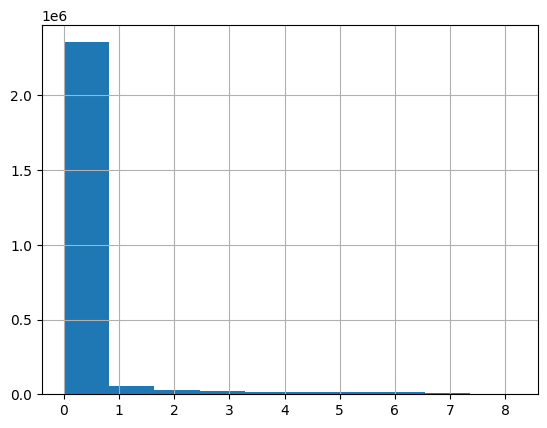

In [9]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.005]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.005]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["score"].hist()
len(train)

In [10]:
from multiprocessing import Pool

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:06<00:00, 41.94it/s]


In [11]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.8246


event   tolerance
onset   12           0.419072
        36           0.750977
        60           0.819949
        90           0.852518
        120          0.876428
        150          0.885841
        180          0.897471
        240          0.908059
        300          0.913624
        360          0.919111
wakeup  12           0.433781
        36           0.759127
        60           0.825318
        90           0.849999
        120          0.871309
        150          0.879421
        180          0.891384
        240          0.903552
        300          0.914306
        360          0.921708
dtype: float64